In [1]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision
import torch.optim as optim
import pytorch_lightning as pl
import copy
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
import torchmetrics
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device=torch.device("cpu")
print(device)

cuda:0


In [3]:
classes=['Covid','No Covid']

In [4]:
num_classes=2
batch_size=4

In [5]:
dataset = torchvision.datasets.ImageFolder(root="./data",transform=transforms.Compose([
                                                            transforms.ToTensor(),
                                                            transforms.Resize([227,227]),
#                                                             transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                                            ]))

In [6]:
print(len(dataset))
trainset,testset=torch.utils.data.random_split(dataset,[round(0.8*len(dataset)),round(0.2*len(dataset))],generator=torch.Generator().manual_seed(42))
trainloader=torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)
testloader=torch.utils.data.DataLoader(testset,batch_size=batch_size,shuffle=False)

8088


In [7]:
def plot_img(img,normal=False):
    npimg=img.numpy()
    if normal:
#     img*mean(0.5) + SD(0.5) => unnormalizing the image
        npimg=img.numpy()/2+0.5
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

In [8]:
%%notify -m "completed"
dataiter=iter(trainloader)
images,labels=dataiter.next()

<IPython.core.display.Javascript object>

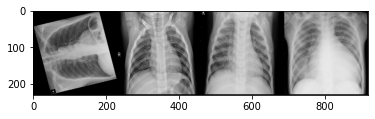

(None, ['Covid', 'No Covid', 'Covid', 'Covid'])

In [9]:
plot_img(torchvision.utils.make_grid(images)),list(map(lambda a: classes[a],labels))

In [10]:
def evaluation(dataloader,model):
    model.eval()
    with torch.no_grad():
        total,correct=0,0
        for data in dataloader:
            inputs,labels=data
            inputs,labels=inputs.to(device),labels.to(device)
            outputs=model(inputs)
    #         print(outputs)
    #         print(outputs,labels)
            m = nn.Sigmoid()
            outputs=m(outputs)
            pred=outputs>=0.5
            pred=pred.flatten()
            total+=labels.size(0)
            # labels=torch.add(labels,-1)
            # print(pred,labels)
    #         print(list(map(lambda a: classes[a],pred)),list(map(lambda a: classes[a],labels)))
            correct+=(pred==labels).sum().item()
    print(correct,total)
    model.train()
    return 100*correct/total

In [11]:
alexnet=models.alexnet(pretrained=True)
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [10]:
class AlexNet(nn.Module):
    def __init__(self,learning_rate=0.001):
        super().__init__()
        self.learning_rate = learning_rate
        # init a pretrained alexnet
        backbone = models.alexnet(pretrained=True)
        layers = list(backbone.children())[:-1]
        self.feature_extractor = nn.Sequential(*layers)
        fc=[]
        fc.extend([nn.Linear(in_features=9216,out_features=512),
           nn.ReLU(),
           nn.Dropout(),
           nn.Linear(in_features=512,out_features=128),
           nn.ReLU(),
           nn.Dropout(),
           nn.Linear(in_features=128,out_features=1)
          ])
        self.classifier=nn.Sequential(*fc)
        for param in self.feature_extractor.parameters():
            param.requires_grad=False
    def forward(self, x):
        with torch.no_grad():
            representations = self.feature_extractor(x).flatten(1)
        x=self.classifier(representations)
        return x;

In [13]:
net=AlexNet()
print(net,net(images).shape)
print(labels)

AlexNet(
  (feature_extractor): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): AdaptiveAvgPool2d(output_size=(6, 6))
  )
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features

In [14]:
for param in net.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([512, 9216])
torch.Size([512])
torch.Size([128, 512])
torch.Size([128])
torch.Size([1, 128])
torch.Size([1])


In [15]:
from sklearn.model_selection import KFold

In [16]:
def k_fold_cv(model,dataset,loss_function,k_folds=5,epochs=10):
    kfold = KFold(n_splits=k_folds, shuffle=True)
    # Initialize optimizer
    results = {}
    for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)): 
        print(f'FOLD {fold}')
        print('--------------------------------')

        # Sample elements randomly from a given list of ids, no replacement.
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
        # Define data loaders for training and testing data in this fold
        trainloader = torch.utils.data.DataLoader(
              dataset, 
              batch_size=batch_size, sampler=train_subsampler)
        testloader = torch.utils.data.DataLoader(
              dataset,
              batch_size=batch_size, sampler=test_subsampler)

        # Init the neural network
        network = model
        reset_weight(network)
        optimizer = optim.Adam(network.parameters())
        # Run the training loop for defined number of epochs
        for epoch in range(0, epochs):

            # Print epoch
            print(f'Starting epoch {epoch+1}')

            # Set current loss value
            current_loss = 0.0

            # Iterate over the DataLoader for training data
            for i, data in enumerate(trainloader, 0):

                # Get inputs
                inputs, targets = data
                inputs = inputs.to(device)
                targets = targets.to(device)
                # Zero the gradients
                optimizer.zero_grad()

                # Perform forward pass
                outputs = network(inputs)
                targets = targets.unsqueeze(-1)
                targets = targets.type_as(outputs)
                # Compute loss
                loss = loss_function(outputs, targets)

                # Perform backward pass
                loss.backward()

                # Perform optimization
                optimizer.step()
                torch.cuda.empty_cache()
                del inputs,targets,outputs
                # Print statistics
                current_loss += loss.item()
                if i % 500 == 499:
                    print('Loss after mini-batch %5d: %.3f' %
                      (i + 1, current_loss / 500))
                    current_loss = 0.0

        # Process is complete.
        print('Training process has finished. Saving the trained model.')
        save_path = f'./Alex-fold-{fold}.pth'
        torch.save(network, save_path)

        # Evaluation for this fold
        correct, total = 0, 0
        with torch.no_grad():

            # Iterate over the test data and generate predictions
            for i, data in enumerate(testloader, 0):
                # Get inputs
                inputs, targets = data
                inputs,targets=inputs.to(device),targets.to(device)
                # Generate outputs
                outputs = network(inputs)
                m = nn.Sigmoid()
                outputs=m(outputs)
                pred=outputs>=0.5
                pred=pred.flatten()
                # Set total and correct
                total += targets.size(0)
                correct += (pred == targets).sum().item()
                del inputs,targets,outputs
                torch.cuda.empty_cache()
            # Print accuracy
            print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
            print('--------------------------------')
            results[fold] = 100.0 * (correct / total)

    # Print fold results
    print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
    print('--------------------------------')
    sum = 0.0
    for key, value in results.items():
        print(f'Fold {key}: {value} %')
        sum += value
    print(f'Average: {sum/len(results.items())} %')

In [17]:
def reset_weight(net):
    net.load_state_dict(torch.load("Alex_originalstate.pt"))

In [18]:
def train(net,dataloader,epochs=15):
    loss_fn=nn.BCEWithLogitsLoss().to(device)
    opt=optim.Adam(params=net.parameters())
    for epoch in range(epochs):
        for i,data in enumerate(dataloader,0):
            inputs,labels=data
            inputs,labels=inputs.to(device),labels.to(device)
            opt.zero_grad()
            outputs=net(inputs)
            labels=labels.unsqueeze(-1)
            labels = labels.type_as(outputs)
    #         print(outputs)
            loss=loss_fn(outputs,labels)
            loss.backward()
            opt.step()
            torch.cuda.empty_cache()
            del inputs,labels,outputs

In [23]:
%%notify -m "Completed"
net=AlexNet().to(device)
torch.save(net.state_dict(),"Alex_originalstate.pt")
loss_fn=nn.BCEWithLogitsLoss().to(device)
data_set=trainset
k_fold_cv(net,data_set,loss_fn,epochs=15)
print("Testing Accuracy: ",evaluation(testloader,net))

FOLD 0
--------------------------------
Starting epoch 1
Loss after mini-batch   500: 0.447
Loss after mini-batch  1000: 0.333
Starting epoch 2
Loss after mini-batch   500: 0.275
Loss after mini-batch  1000: 0.231
Starting epoch 3
Loss after mini-batch   500: 0.209
Loss after mini-batch  1000: 0.258
Starting epoch 4
Loss after mini-batch   500: 0.202
Loss after mini-batch  1000: 0.231
Starting epoch 5
Loss after mini-batch   500: 0.206
Loss after mini-batch  1000: 0.177
Starting epoch 6
Loss after mini-batch   500: 0.191
Loss after mini-batch  1000: 0.166
Starting epoch 7
Loss after mini-batch   500: 0.177
Loss after mini-batch  1000: 0.171
Starting epoch 8
Loss after mini-batch   500: 0.149
Loss after mini-batch  1000: 0.170
Starting epoch 9
Loss after mini-batch   500: 0.137
Loss after mini-batch  1000: 0.160
Starting epoch 10
Loss after mini-batch   500: 0.151
Loss after mini-batch  1000: 0.148
Starting epoch 11
Loss after mini-batch   500: 0.135
Loss after mini-batch  1000: 0.149
S

<IPython.core.display.Javascript object>

In [24]:
reset_weight(net)
train(net.to(device),trainloader)

In [25]:
torch.save(net,'Alex-final.pth')

In [7]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

In [8]:
def report(dataloader,model):
    y_true,y_pred=torch.tensor([]),torch.tensor([])
    model.eval()
    with torch.no_grad():
        total,correct=0,0
        for data in dataloader:
            inputs,labels=data
            inputs,labels=inputs.to(device),labels.to(device)
            outputs=model(inputs)
    #         print(outputs)
    #         print(outputs,labels)
            m = nn.Sigmoid()
            outputs=m(outputs)
            pred=outputs>=0.5
            pred=pred.flatten()
            y_true=torch.cat((y_true,copy.deepcopy(labels.cpu())),0)
            y_pred=torch.cat((y_pred,copy.deepcopy(pred.cpu())),0)
#             print(y_pred,y_true,y_pred==y_true,pred==labels)
            total+=labels.size(0)
            # labels=torch.add(labels,-1)
            # print(pred,labels)
    #         print(list(map(lambda a: classes[a],pred)),list(map(lambda a: classes[a],labels)))
            correct+=(pred==labels).sum().item()
#             print((pred==labels).sum())
    print("Accuracy: ",accuracy_score(y_true,y_pred))
    print("Precision: ",precision_score(y_true,y_pred))
    print("Recall: ",recall_score(y_true,y_pred))
    print("F1-Score: ",f1_score(y_true,y_pred))
    print("AUC: ",roc_auc_score(y_true,y_pred))
    print(correct,total)
#     print(y_true,y_pred)
    y_pred=y_pred.flatten()
    y_true=y_true.flatten()
#     print(classification_report(y_true, y_pred))
    
    model.train()
    return 100*correct/total

In [12]:
print(report(testloader,net))

Accuracy:  0.9511742892459827
Precision:  0.9372781065088758
Recall:  0.9682151589242054
F1-Score:  0.952495490078172
AUC:  0.9509825794621027
1539 1618
95.11742892459827
